<h2>Photo-z validation metrics on Resampled Alhambra/Cosmos Data</h2>

This notebook shows how to load a .yaml /.p pickle file from all 100 of the resampled Alhambra/Cosmos validation files.

We then determine the error, from the spread of metric values from the 100 RS validation data, and also from the Cosmic Variance analysis.

*You will need to change the path and path_to_pickle_output_file  lines in the below cell*


In [25]:
import yaml
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pickle
import bz2
import bh_photo_z_validation as pval
path = '/home/will/work/photz/photoz-wg/validation/'
#path = '/home/will/work/BPZ/valid_Dec/'

#these are the current best template and ML codes. Can you beat them!
#['point_LSS_MLv2.p.bz2', 'point_LSS_TPLv2.p.bz2', 'point_WL_MLv2.p.bz2','point_WL_TPLv2.p.bz2']
#'point_Y1_MLv2.p.bz2','point_Y1_TPLv2.p.bz2']
#point_COSMOSnonNGMIX point_COSMOSnonNGMIX.p
path_to_pickle_output_file = path + 'point_MFZHT.p'

path_to_cos_var_pickle_file = path + 'cosmic_variance_data/cosvariance_cosmos_z_metrics.zbins.p.bz2'
path_to_cos_var_pickle_file = path + '/cosmic_variance_data/cosvariance_cosmos_z_metrics1cos2alh.zbins.p.bz2'

In [26]:
class scaled_error():
    def __init__(self, const, scaling_type):
        self.const = const
        self.scaling = None
        if scaling_type == 'one_plus_z':
            self.scaling = self.one_plus_z 
        else:
            self.scaling = self.const_with_z
        
    def one_plus_z(self, z):
        return np.array((1 + z) * self.const)
    
    def const_with_z(self, z):
        return np.array(len(z) * [self.const])
    

In [27]:
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (24, 8)
plt.rcParams.update({'font.size': 32, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 16,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 22,
                    'ytick.labelsize': 22})

<h3>Metrics of interest</h3>

Let us decide which metrics we want to measure. Edit this list with metrics that we measured from the validation script. Look at the structure of the validation .yaml file to understand this indexing.

In [28]:
#metrics to plot.
#'metric_name': [WHICH_Z_COLUMN, WAY_TO_COMPARE_DISTs, METRIC, [,MEASURED_ON]]
metrics = {'sigma_68': ['MEAN_Z', 'metrics_diffz','bh_photo_z_validation.sigma_68', 'delta_z'],
           'outFrac_2sigma68': ['MEAN_Z', 'metrics_diffz', 
                                'bh_photo_z_validation.outFrac_2sigma68', 'delta_z'],
           'outFrac_3sigma68': ['MEAN_Z', 'metrics_diffz', 
                                'bh_photo_z_validation.outFrac_3sigma68', 'delta_z'],
           'median': ['MEAN_Z', 'metrics_diffz', 'numpy.median', 'delta_z'],
           'wl_metric': ['Z_MC', 'metrics_z1_z2', 'bh_photo_z_validation.wl_metric']
           }

#which bining column should we choose?
bin_column = 'MEAN_Z'

#requirements from science handbook
# http://des-docdb.fnal.gov:8080/cgi-bin/RetrieveFile?docid=20&filename=sciReq-9.86.pdf&version=32
# http://des-docdb.fnal.gov:8080/cgi-bin/ShowDocument?docid=1719
requirements = {'sigma_68':{'value': 0.12, 'error': scaled_error(0.003, 'const')},
                'wl_metric': {'value': 0.02, 'error': scaled_error(0.003, 'const')},
                'outFrac_2sigma68': { 'value': 0.1 , 'error': scaled_error(0.001, 'const') },
                'outFrac_3sigma68': {'value': 0.015, 'error': scaled_error(0.0015, 'const') },
                'median': {'value': 0, 'error': scaled_error(0.001, 'one_plus_z') },
                }

#plotting ranges
plt_range = {'sigma_68': [0, 0.5],
            'wl_metric': [0, 0.1],
            'outFrac_2sigma68': [0, 0.3],
            'outFrac_3sigma68': [0, 0.3],
             'median' : [-0.2, 0.2],
             'outlier_fraction': [0,70]
            }

metric_latex = {
    'sigma_68' :'$\sigma_{68}(z_{true} - z_{pred})$',
    'wl_metric': '$|<dNdz_{true}> - <dNdz_{pred}>|$',
    'outFrac_2sigma68': '$f(>2*\sigma_{68})$',
    'outFrac_3sigma68': '$f(>3*\sigma_{68})$',
    'median' : '$\mu(z_{true} - z_{pred})$',
    'outlier_fraction': '$f(|(z_{true} - z_{pred})/(1+z_{true})|>1.5)$'
}

In [29]:
#bns_str = '[0, 0.1, 0.2, 0.43, 0.63, 0.9, 1.3]'.replace(' ','')
bns_str = '[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]'.replace(' ','')

<h3>Load results files</h3>

Now let's load the .p [pickle] file output from the validation pipeline, and also the cosmic variance results we calculated elsewhere [Ask Youngsoo/Ben/Markus for details].


In [30]:
if path_to_pickle_output_file[-4:] == '.bz2':
    res = pickle.load(bz2.BZ2File(path_to_pickle_output_file, 'r'))
else:
    res = pickle.load(open(path_to_pickle_output_file, 'r'))

cosvar = pickle.load(bz2.BZ2File(path_to_cos_var_pickle_file, 'r'))

test_dict = cosvar[0][bns_str]['test']

#get the original bins in the test .yaml file
bins = np.array(eval(test_dict['bins'][0][bin_column]))

KeyError: '[0.5,0.6,0.7,0.8,0.9,1.0,1.1]'

In [21]:
files = res.keys()
def get_val(dct, ky):
    return dct[ky]

sample = files[0].split('/')[-1]#.split('ScienceCase')[0].split('_.')[1]

code = 'ML'
if 'bpz' in files[0]:
    code = 'TPL'
    
print (sample + ' ' + code)

WL_CLASS_magerr_trim.rescaled.cosmos.bpz.fits TPL


In [22]:
#get the error component from the resampled Alhambra data
    
m_res = {} #temporary value storage
metric_res = {} #this holds the median metric value, and std from the RS samples. Also the binned results

for m in metrics.keys(): 
    met_kys = metrics[m]
    m_res[m] ={'VALUES': [], 'BINS_ID': {}}
    metric_res[m] = {'VALUES':[], 'BINS_ID': {}}

    for f in files:
        test_name = res[f].keys()[0]
        
        for j, ky in enumerate(met_kys):
            if j ==0:
                dct = get_val(res[f][test_name], ky)
            else:
                dct = get_val(dct, ky)
        
        #get the unbinned value
        m_res[m]['VALUES'].append(dct['VALUE'])
        
        #Each resampled file can have a different <z> per bin, so find the 
        #index of the original bins [in test.yaml] that corresponds to this redshift
        for j, zbn in enumerate(dct['bins'][bin_column]['BIN_CENTERS']):
            if np.isfinite(zbn) and zbn > 0:
                indj = np.where((zbn < bins[1:]) * (zbn >= bins[0:-1]))[0][0]
                if indj not in m_res[m]['BINS_ID']:
                    m_res[m]['BINS_ID'][indj] = {}
                    m_res[m]['BINS_ID'][indj]['BIN_CENTER'] = []
                    m_res[m]['BINS_ID'][indj]['VALUE'] = []
                
                m_res[m]['BINS_ID'][indj]['BIN_CENTER'].append(zbn)
                m_res[m]['BINS_ID'][indj]['VALUE'].append(dct['bins'][bin_column]['VALUE'][j])


    #get the median value and the error component from the 68% [standard deviation] of the resampled data.
    metric_res[m]['SIGMA'] = pval.sigma_68(m_res[m]['VALUES'])
    metric_res[m]['VALUES'] = np.median(m_res[m]['VALUES']) 

    for j, indj in enumerate(m_res[m]['BINS_ID'].keys()):
        
            metric_res[m]['BINS_ID'][indj] = {}
            metric_res[m]['BINS_ID'][indj]['BIN_CENTER'] = np.median(m_res[m]['BINS_ID'][indj]['BIN_CENTER'])
        
            #overwrite the lists to save some memory space
            metric_res[m]['BINS_ID'][indj]['SIGMA'] =  pval.sigma_68(m_res[m]['BINS_ID'][indj]['VALUE'])
            metric_res[m]['BINS_ID'][indj]['VALUE'] = np.median(m_res[m]['BINS_ID'][indj]['VALUE'])
       

<h3>Next add in CosmicVariance error component</h3>

We repeat the above, and additionally calculate the error on each metric from cosmic variance. and from validating on high quality photo-z instead of spec-z

In [23]:
#this will hold the median metric values, RS errors, AND CosVar Errors
sample_var_cosz = {}
sample_var_truez = {}

for m in metrics.keys(): 
    met_kys = metrics[m]

    sample_var_cosz[m] = {'VALUES':[], 'BINS_ID': {}}
    sample_var_truez[m] = {'VALUES':[], 'BINS_ID': {}}
    
    #we only care about the bin numbers that we have measured data in
    for j, indj in enumerate(metric_res[m]['BINS_ID']):
        sample_var_truez[m]['BINS_ID'][indj] = {}
        sample_var_cosz[m]['BINS_ID'][indj] = {}
        
        sample_var_truez[m]['BINS_ID'][indj]['VALUE'] = []
        sample_var_cosz[m]['BINS_ID'][indj]['VALUE'] = []
        
        sample_var_truez[m]['BINS_ID'][indj]['BIN_CENTER'] = []
        sample_var_cosz[m]['BINS_ID'][indj]['BIN_CENTER'] = []

                
    #loop over all simulated files.
    for f in cosvar:
        for j, ky in enumerate(met_kys):
            if j ==0:
                cos_dct = get_val(f[bns_str]['COSMOS_Z'], ky)
                z_dct = get_val(f[bns_str]['Z'], ky)
            else:
                cos_dct = get_val(cos_dct, ky)
                z_dct = get_val(z_dct, ky)

        #get the value for all unbinned data        
        sample_var_cosz[m]['VALUES'].append(cos_dct['VALUE'])    
        sample_var_truez[m]['VALUES'].append(z_dct['VALUE'])
  
        #determine which bin we are referring to
        for j, zbn in enumerate(cos_dct['bins'][bin_column]['BIN_CENTERS']):
            indj = np.where((zbn < bins[1:]) * (zbn >= bins[0:-1]))[0][0]
            
            #if we care about this bin, then save values [and what was the center for this realisiation.]
            if indj in sample_var_cosz[m]['BINS_ID'].keys():
                sample_var_cosz[m]['BINS_ID'][indj]['BIN_CENTER'].append(cos_dct['bins'][bin_column]['BIN_CENTERS'][j])
                sample_var_cosz[m]['BINS_ID'][indj]['VALUE'].append(cos_dct['bins'][bin_column]['VALUE'][j])
            
        for j, zbn in enumerate(z_dct['bins'][bin_column]['BIN_CENTERS']):  
            indj = np.where((zbn < bins[1:]) * (zbn >= bins[0:-1]))[0][0]
            
            if indj in sample_var_truez[m]['BINS_ID'].keys():
                sample_var_truez[m]['BINS_ID'][indj]['BIN_CENTER'].append(z_dct['bins'][bin_column]['BIN_CENTERS'][j])
                sample_var_truez[m]['BINS_ID'][indj]['VALUE'].append(z_dct['bins'][bin_column]['VALUE'][j])
            
    
    #calculate the 68% spread of these metric values
    sample_var_cosz[m]['SIGMA']  = pval.sigma_68(sample_var_cosz[m]['VALUES'])
    sample_var_truez[m]['SIGMA']  = pval.sigma_68(sample_var_truez[m]['VALUES'])

    sample_var_cosz[m]['VALUES']  = np.median(sample_var_cosz[m]['VALUES'])
    sample_var_truez[m]['VALUES']  = np.median(sample_var_truez[m]['VALUES'])
    
    #for each bin number, calculate the bin center, sigmas and mean value
    for j, indj in enumerate(sample_var_truez[m]['BINS_ID']):
        sample_var_truez[m]['BINS_ID'][indj]['BIN_CENTER'] = np.median(sample_var_truez[m]['BINS_ID'][indj]['BIN_CENTER'])
        sample_var_truez[m]['BINS_ID'][indj]['SIGMA'] = pval.sigma_68(sample_var_truez[m]['BINS_ID'][indj]['VALUE'])
        sample_var_truez[m]['BINS_ID'][indj]['VALUE'] = np.median(sample_var_truez[m]['BINS_ID'][indj]['VALUE'])
        
    for j, indj in enumerate(sample_var_cosz[m]['BINS_ID']):
        sample_var_cosz[m]['BINS_ID'][indj]['BIN_CENTER'] = np.median(sample_var_cosz[m]['BINS_ID'][indj]['BIN_CENTER'])
        sample_var_cosz[m]['BINS_ID'][indj]['SIGMA'] = pval.sigma_68(sample_var_cosz[m]['BINS_ID'][indj]['VALUE'])
        sample_var_cosz[m]['BINS_ID'][indj]['VALUE'] = np.median(sample_var_cosz[m]['BINS_ID'][indj]['VALUE'])
        

<h3>Plot both error components</h3>

Let's add the cosmic variance error in quadrature to the ReSample error, and plot the results for each metric, as a function of the tomographic bins.

TPLWL_CLASS_magerr_trim.rescaled.cosmos.bpz.fits
metric: | outFrac_3sigma68
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
0.0560 \pm \bf 0.0017  ( 0.0e+00 \pm 1.7e-03 \pm 1.9e-04) \\ 
metric: | outFrac_2sigma68
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
0.1110 \pm \bf 0.0016  ( 0.0e+00 \pm 1.6e-03 \pm 2.5e-04) \\ 
metric: | median
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
-0.0031 \pm \bf 0.0055  ( 0.0e+00 \pm 5.5e-03 \pm 6.0e-05) \\ 
metric: | sigma_68
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
0.1747 \pm \bf 0.0073  ( 0.0e+00 \pm 7.3e-03 \pm 2.5e-04) \\ 
metric: | wl_metric
Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\
0.0067 \pm \bf 0.0088  ( 0.0e+00 \pm 8.8e-03 \pm 1.7e-04) \\ 


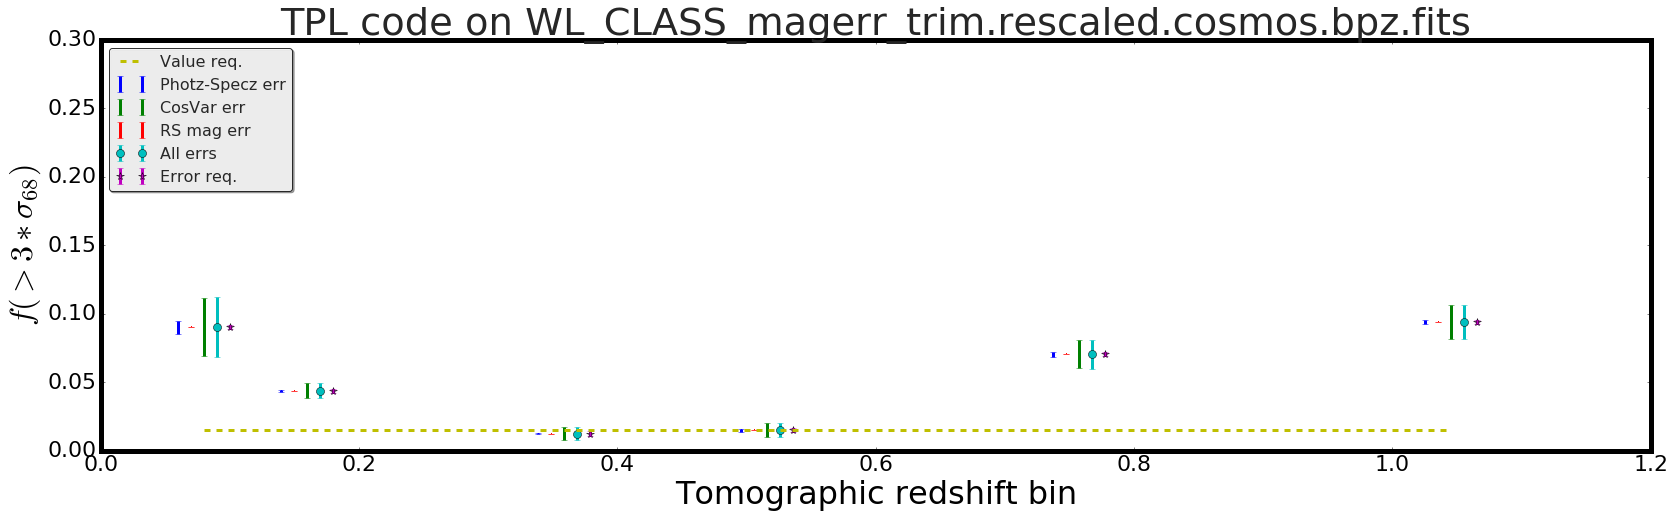

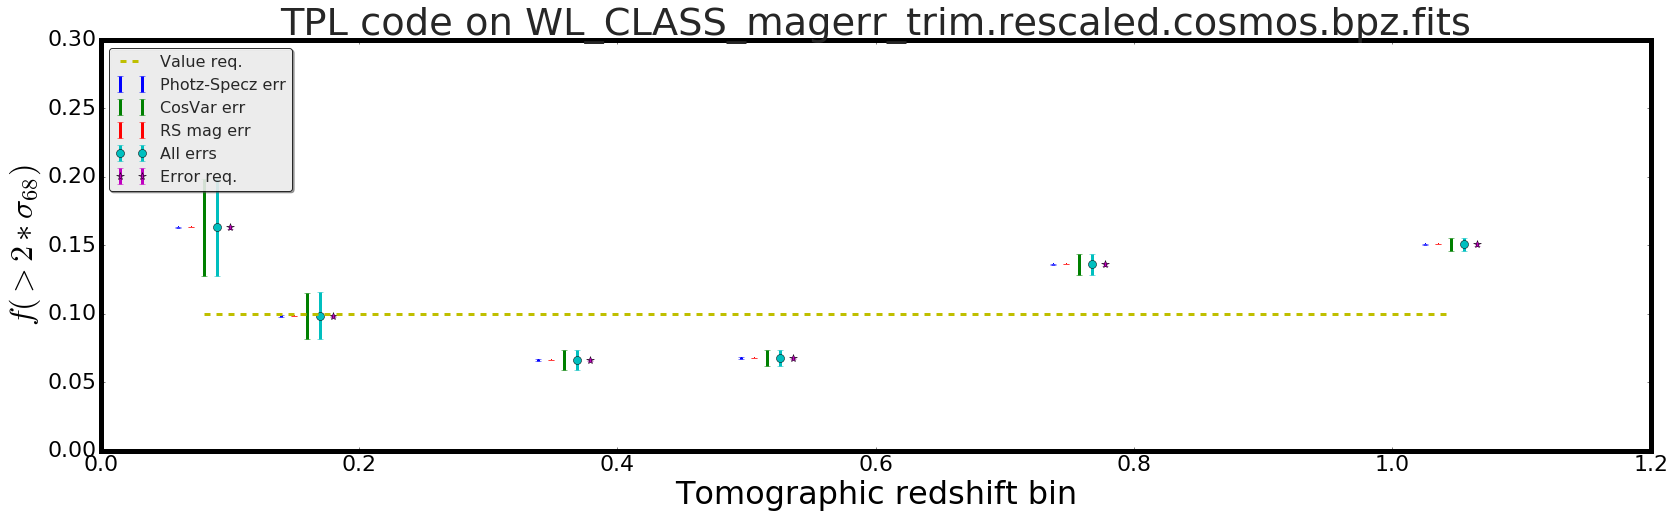

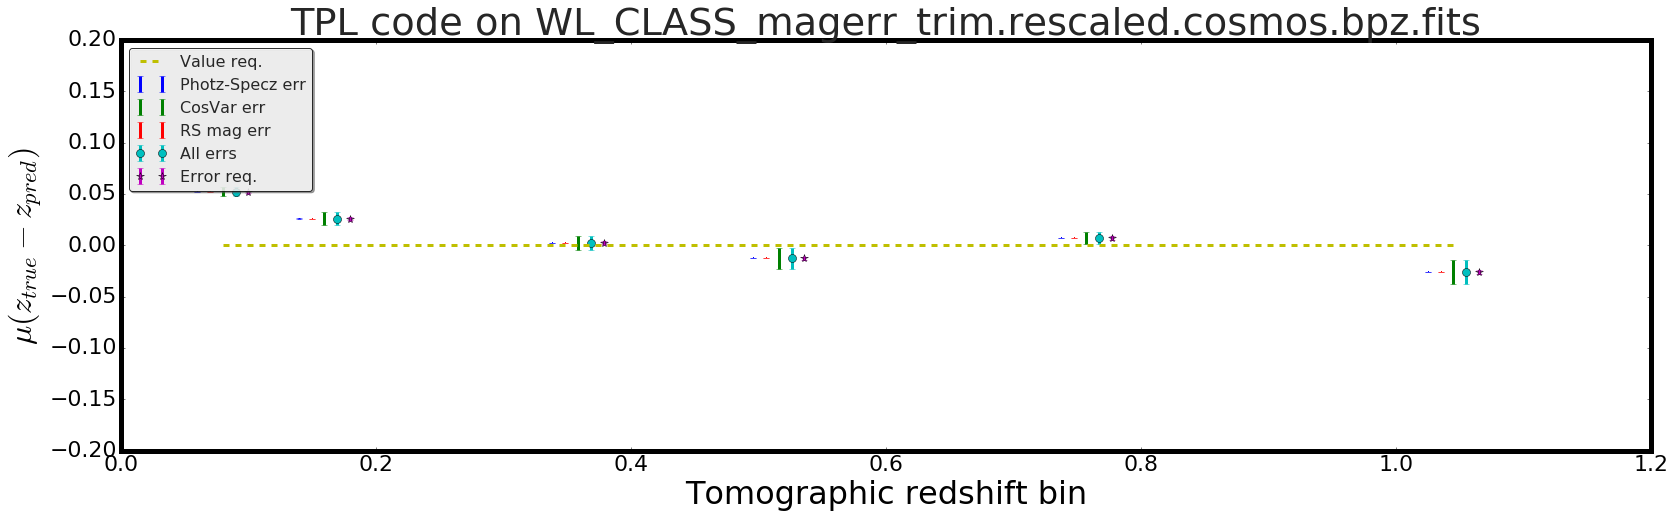

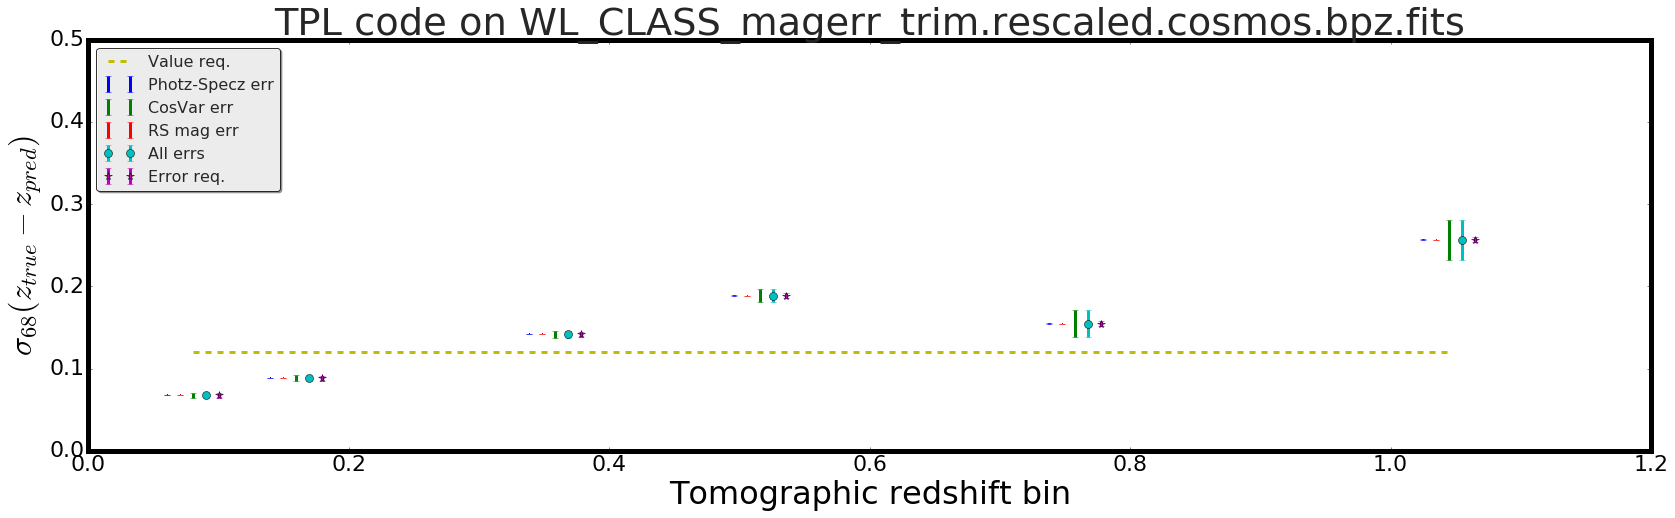

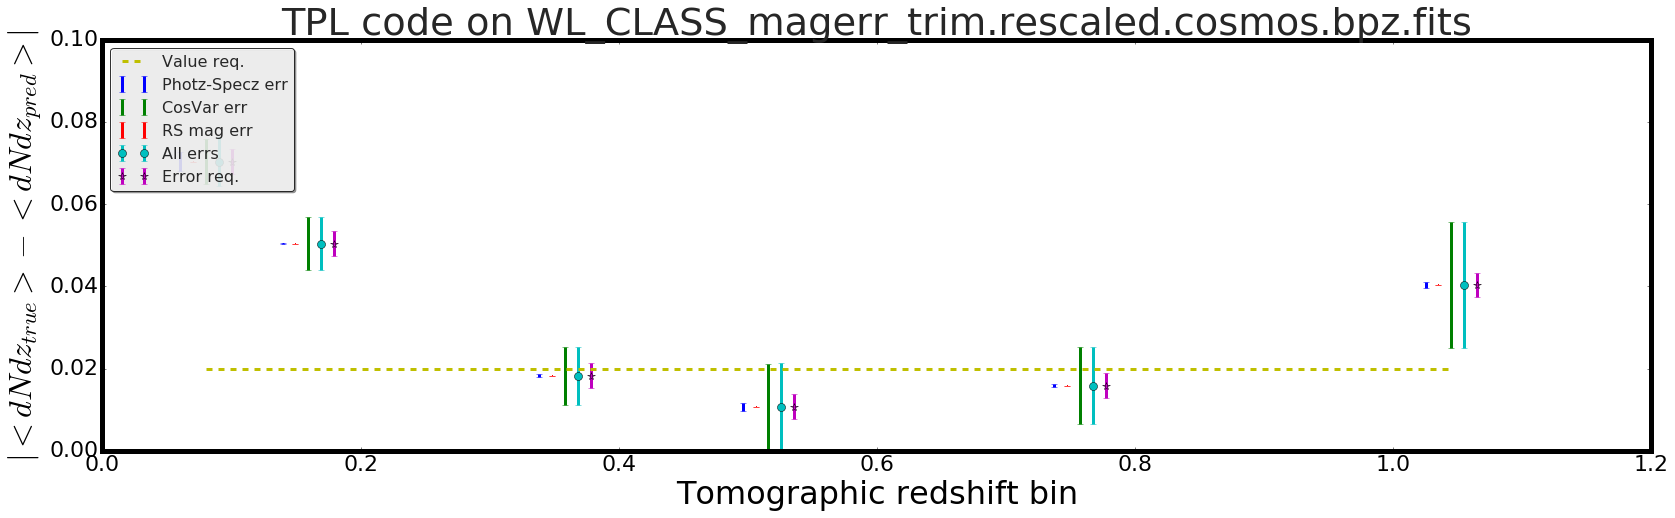

In [24]:
Ms = 8
lw = 3
print (code + sample)

cos_vv = {}
for m in metric_res:
    f= plt.figure()
    indjs = metric_res[m]['BINS_ID'].keys()
    z = np.array([metric_res[m]['BINS_ID'][indj]['BIN_CENTER'] for indj in indjs])
    errRS = np.array([metric_res[m]['BINS_ID'][indj]['SIGMA'] for indj in indjs]) #err from ReSample
    errCV = np.array([sample_var_cosz[m]['BINS_ID'][indj]['SIGMA'] for indj in indjs]) #err from CosVar to photo-z
    errNonSpecZ = np.array([np.abs(sample_var_cosz[m]['BINS_ID'][indj]['SIGMA'] - sample_var_truez[m]['BINS_ID'][indj]['SIGMA']) 
                             for indj in indjs]) #err from COSMOS photo-z to true-z
    cos_vv[m] = errCV
    err = np.sqrt(errRS**2 + errCV**2 + errNonSpecZ**2) #add in quadrature
    y = np.array([metric_res[m]['BINS_ID'][indj]['VALUE'] for indj in indjs])
    
    plt.errorbar(np.array(z)-0.02, y, yerr=errNonSpecZ, fmt=',', markersize=str(Ms), elinewidth=lw,label='Photz-Specz err')
    plt.errorbar(np.array(z), y, yerr=errCV , fmt=',',markersize=str(Ms), elinewidth=lw, label='CosVar err')
    plt.errorbar(np.array(z)-0.01, y, yerr=errRS, fmt=',', markersize=str(Ms), elinewidth=lw,label='RS mag err')
    plt.errorbar(np.array(z)+0.01, y, yerr=err, fmt='o',markersize=str(Ms), elinewidth=lw, label='All errs')
    
    #get requirements:
    if m in requirements:
        err_req = requirements[m]['error'].scaling(np.array(z))
        plt.errorbar(np.array(z)+0.02, y, yerr=err_req, fmt='*',markersize=str(Ms), elinewidth=lw, label='Error req.')
        
        val_req = [requirements[m]['value']]*len(z)
        plt.plot(np.array(np.sort(z)), val_req,'--', linewidth=3,label='Value req.')
    
    plt.xlabel('Tomographic redshift bin')
    plt.title(code + ' code on ' + sample)
    plt.ylim(plt_range[m])
    plt.ylabel(metric_latex[m])
    plt.legend(loc=2)
    plt.tight_layout()
    plt.savefig(code + sample + m + '.pdf')
    
    
    print ('metric: | {:}'.format(m))
    mean = metric_res[m]['VALUES']
    rsErr = metric_res[m]['SIGMA']
    cosVarErr = sample_var_cosz[m]['SIGMA']
    photSpecErr = np.abs(sample_var_cosz[m]['SIGMA'] - sample_var_truez[m]['SIGMA'])
    err = np.sqrt(rsErr**2 + cosVarErr**2 + photSpecErr**2)
    print ('Mean & ReSamp Err & SampVar Err & PhotSpec Err & Combined Err \\\\')
    print ('{:0.4f} \pm \\bf {:0.4f}  ( {:0.1e} \pm {:0.1e} \pm {:0.1e}) \\\\ '.format(mean,err, rsErr, cosVarErr, photSpecErr))

<h3>Generating the sample (cosmic) variance</h3>

This code snippet loads in a heap of validation script outputs, measured on each patch in a simulation, and stores the resulting list in the cosmic variance file in the validation directory.

In [2]:
files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/Cosmo_*.p')
files = [i for i in files if 'Alh' not in i and 'e5' not in i]
res = []
for fil in files:
    r = pickle.load(open(fil, 'r'))
    res.append(r)
print len(res)
pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_cosmos_z_metrics.zbins.p.bz2', 'w'))

files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/Cosmo_1xAlh*.p')
res = []
for fil in files:
    r = pickle.load(open(fil, 'r'))
    res.append(r)
print len(res)
pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_cosmos_z_metrics1cos1alh.zbins.p.bz2', 'w'))

files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/Cosmo_2xAlh*.redshift.metrics.p')
files = [i for i in files if 'e5' not in i]
res = []
for fil in files:
    r = pickle.load(open(fil, 'r'))
    res.append(r)
print len(res)
pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_cosmos_z_metrics1cos2alh.zbins.p.bz2', 'w'))


155
0
92


In [ ]:
import copy
cos_noalh = copy.deepcopy(cos_vv)

In [ ]:
mm = ['wl_metric', 'sigma_68', 'median', 'outFrac_2sigma68']

for m in mm:
    plt.plot(z, (cos_vv[m] - cos_noalh[m])*100/cos_vv[m], label=m)

plt.legend()
plt.xlabel('Tomographic bin')
plt.ylabel('CosVar uncertainty Reduction with Y3Alh')
f = plt.figure()
cnt=0
col = ['red', 'blue', 'green', 'yellow']
for m in mm:
    plt.plot(z, cos_noalh[m] , '--',color=col[cnt], label='cos' + m)
    plt.plot(z, cos_vv[m] ,color=col[cnt],  label='cos2alh' + m, linewidth=2 )
    
        #get requirements:
    if m in requirements:
        err_req = requirements[m]['error'].scaling(np.array(z))
        plt.plot(np.array(z), err_req,'o-', color=col[cnt], label='Error req.', linewidth=1 )
    cnt += 1    
plt.legend()
plt.xlabel('Tomographic bin')
plt.ylabel('CosVar uncertainty [Cos field]')   
